# AUTOMATIC

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(8539.0, 8545.0)


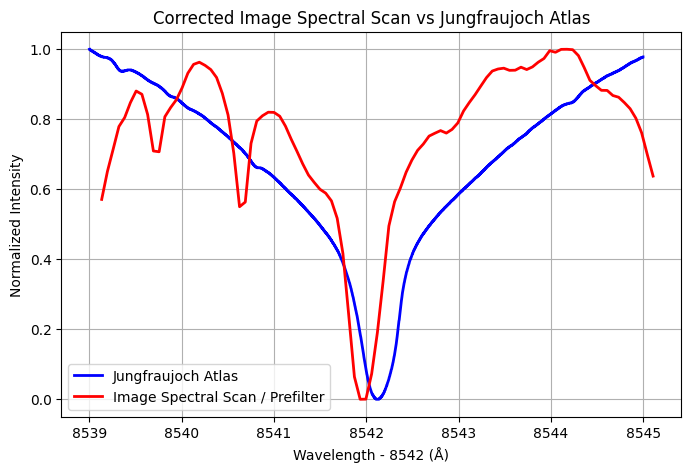

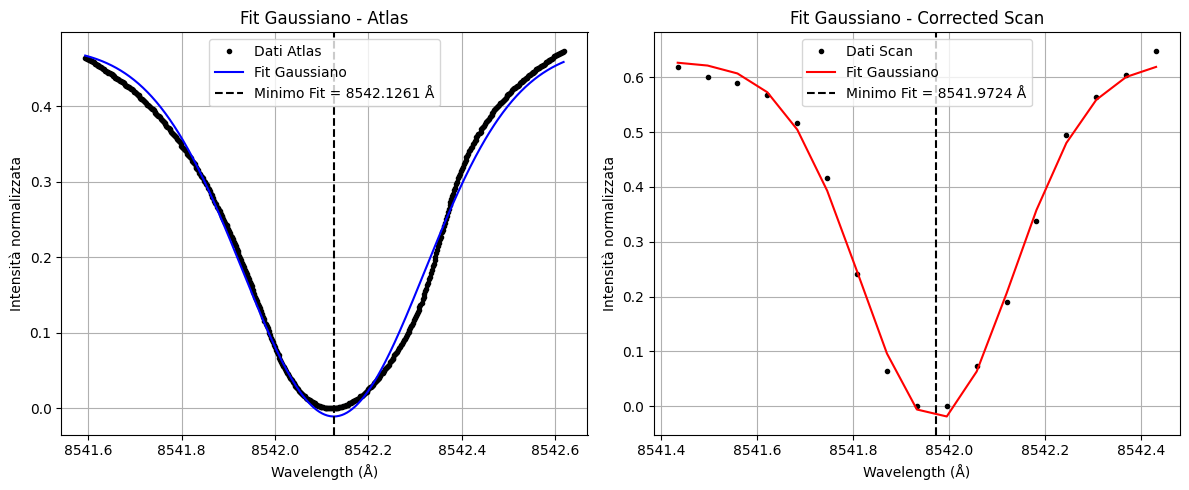

Shift (da fit gaussiano): -0.1538 Å
-5.400337608545579
Processing first file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/s000.ImagingSpectralScan_8542.fits
DATE-BEG = 2016-05-20T12:59:44.149


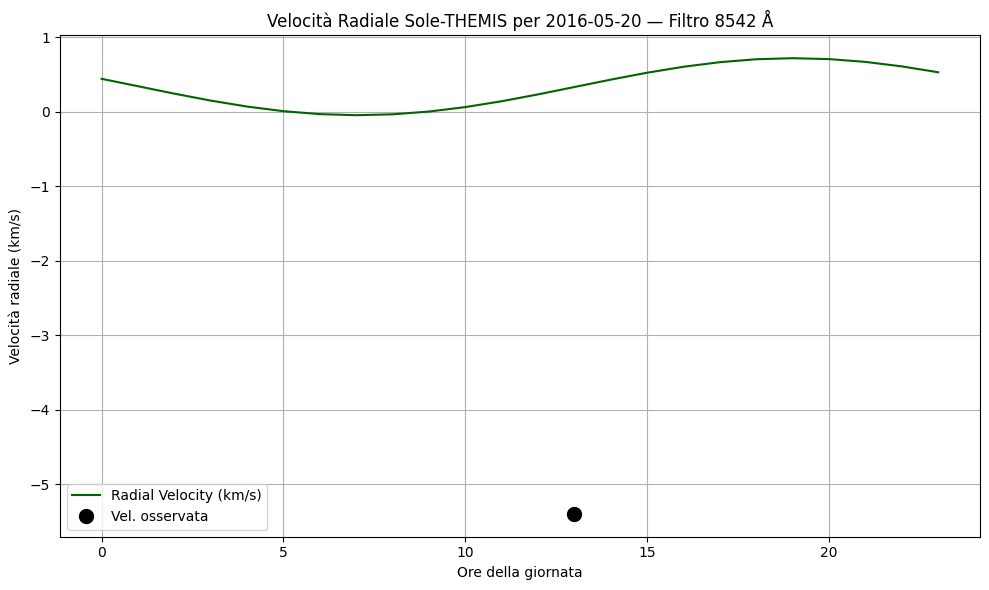

In [9]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.optimize import curve_fit

# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# === Selezione del filtro ===
selected_filter = "8542"  # Cambia in "6173", ecc.

filter_params = {
    "8542": {
        "wave_offset": 8542.12,
        "prefilter_key": "prefilt8542_ref_main",
        "jung_range": (8539.0, 8545.0)
    },
    "6173": {
        "wave_offset": 6173.34,
        "prefilter_key": "prefilt6173_ref_main",
        "jung_range": (6170.0, 6175.0)
    }
}

params = filter_params[selected_filter]
jung_range = params["jung_range"]

# Trova i file FITS
fits_files = glob.glob(f"/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/*{selected_filter}.fits")
if not fits_files:
    raise FileNotFoundError("No FITS files found.")

# Estrai REL_WAVE da tutti i file
rel_wave_values = []
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            try:
                rel_wave_values.append(hdu.header['REL_WAVE'])
            except KeyError:
                continue

# Calcola le lunghezze d'onda reali
wave_offset = params["wave_offset"]
wave_im = np.array(rel_wave_values) + wave_offset


# jung_range = (wave_im.min(), wave_im.max())

# if selected_filter == "6173":
#     jung_range = (6170.0, 6175)
# else:
#     jung_range = (wave_im.min(), wave_im.max())


# params = filter_params[selected_filter]

# Trova i file FITS
fits_files = glob.glob(f"/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/*{selected_filter}.fits")
if not fits_files:
    raise FileNotFoundError("No FITS files found.")

# Estrai REL_WAVE da tutti i file
rel_wave_values = []
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            try:
                rel_wave_values.append(hdu.header['REL_WAVE'])
            except KeyError:
                continue

# Trova una immagine valida per definire le regioni
image_data = None
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            if hdu.data is not None and hdu.data.ndim == 2:
                image_data = hdu.data
                break
    if image_data is not None:
        break

if image_data is None:
    raise ValueError("No valid image data found.")

# Definizione regioni
half_size = 25
h, w = image_data.shape
y_center = h // 2
x_center_1 = w // 2 - 220
x_center_2 = w // 2 + 220
x1s, x1e = x_center_1 - half_size, x_center_1 + half_size
x2s, x2e = x_center_2 - half_size, x_center_2 + half_size
ys, ye = y_center - half_size, y_center + half_size

# Media dei valori centrali per ogni HDU (escludendo il PRIMARY)
central_regions = []
with fits.open(fits_files[0]) as hdul:
    for hdu in hdul[1:]:
        data = hdu.data
        if data is not None:
            region1 = data[ys:ye, x1s:x1e]
            region2 = data[ys:ye, x2s:x2e]
            avg_intensity = np.mean([region1.mean(), region2.mean()])
            central_regions.append(avg_intensity)

central_regions = np.array(central_regions)

# Normalizza
central_regions = (central_regions - central_regions.min()) / (central_regions.max() - central_regions.min())

# Rimuovi eventuali zeri agli estremi
start_zero = central_regions[0] == 0
end_zero = central_regions[-1] == 0

if start_zero:
    central_regions = central_regions[1:]
    wave_im = np.array(rel_wave_values)[1:]
else:
    wave_im = np.array(rel_wave_values)

if end_zero:
    central_regions = central_regions[:-1]
    wave_im = wave_im[:-1]

# Aggiusta il range spettrale
wave_im = wave_im + params["wave_offset"]

# Leggi spettro atlas
def read_jung_fits(file, w1, w2, subsample=1):
    skip = round((w1 - 3601) * 1000)
    np_points = int((w2 - w1 + 1) * 500)
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]
    if sp.dtype.byteorder != '=':
        sp = sp.byteswap().view(sp.dtype.newbyteorder('S'))
    sp = sp.astype(np.float32) * 0.1
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1
    return wave, sp


wave, spectrum = read_jung_fits(
    '/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits',
        w1=jung_range[0],
        w2=jung_range[1]-1
)

print(jung_range)
spectrum_norm = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())

# Leggi prefilter
file_list = glob.glob(f"/content/drive/MyDrive/IBIS_SWG/input/prefilter/*{selected_filter}*.sav")
if not file_list:
    raise FileNotFoundError("No prefilter file found.")
prefilter = readsav(file_list[0])
main_filter = prefilter[params["prefilter_key"]]

old_x = np.linspace(0, 1, len(main_filter))
new_x = np.linspace(0, 1, len(central_regions))
prefilter_interp = np.interp(new_x, old_x, main_filter)

# Divisione robusta (evita divisione per valori troppo piccoli)
prefilter_interp_safe = np.where(prefilter_interp < 0.05, np.nan, prefilter_interp)
corrected_scan = central_regions / prefilter_interp_safe

# Rimpiazza i NaN generati dalla divisione
corrected_scan = np.where(np.isnan(corrected_scan), np.nanmedian(corrected_scan), corrected_scan)

# Normalizzazione robusta usando percentili
vmin = np.percentile(corrected_scan, 1)
vmax = np.percentile(corrected_scan, 99)
corrected_scan = (corrected_scan - vmin) / (vmax - vmin)
corrected_scan = np.clip(corrected_scan, 0, 1)  # assicura che sia tra 0 e 1

# Plot confronto
plt.figure(figsize=(8, 5))
plt.plot(wave, spectrum_norm, label="Jungfraujoch Atlas", color='b', linewidth=2)
plt.plot(wave_im , corrected_scan, label="Image Spectral Scan / Prefilter", color='r', linewidth=2)
plt.xlabel(f"Wavelength - {selected_filter} (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Corrected Image Spectral Scan vs Jungfraujoch Atlas")
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/corrected_scan_vs_atlas.png')
plt.show()

# Fit gaussiano
def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

def fit_gaussian_near_min(wavelengths, intensities, window_angstrom):
    min_idx = np.argmin(intensities)
    pixel_scale = wavelengths[1] - wavelengths[0]
    window_pix = int(window_angstrom / pixel_scale)
    start = max(0, min_idx - window_pix // 2)
    end = min(len(intensities), min_idx + window_pix // 2 + 1)

    x = wavelengths[start:end]
    y = intensities[start:end]

    a0 = y.min() - y.max()
    x0 = x[np.argmin(y)]
    sigma0 = 0.2
    offset0 = y.max()

    try:
        popt, _ = curve_fit(gaussian, x, y, p0=[a0, x0, sigma0, offset0])
        fitted_min = popt[1]
    except RuntimeError:
        fitted_min = x[np.argmin(y)]
    return fitted_min, x, y, gaussian(x, *popt)

lambda_atlas, x_fit_a, y_fit_a, gauss_fit_a = fit_gaussian_near_min(wave, spectrum_norm, 1.0)
lambda_scan, x_fit_s, y_fit_s, gauss_fit_s = fit_gaussian_near_min(wave_im, corrected_scan, 1.0)

# Plot fit
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_fit_a, y_fit_a, 'k.', label='Dati Atlas')
plt.plot(x_fit_a, gauss_fit_a, 'b-', label='Fit Gaussiano')
plt.axvline(lambda_atlas, color='k', linestyle='--', label=f'Minimo Fit = {lambda_atlas:.4f} Å')
plt.title("Fit Gaussiano - Atlas")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensità normalizzata")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_fit_s, y_fit_s, 'k.', label='Dati Scan')
plt.plot(x_fit_s, gauss_fit_s, 'r-', label='Fit Gaussiano')
plt.axvline(lambda_scan, color='k', linestyle='--', label=f'Minimo Fit = {lambda_scan:.4f} Å')
plt.title("Fit Gaussiano - Corrected Scan")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensità normalizzata")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/gaussian_fit_minima.png')
plt.show()

# Calcolo dello shift
shift_angstrom = lambda_scan - lambda_atlas
print(f"Shift (da fit gaussiano): {shift_angstrom:.4f} Å")


!pip install skyfield

from skyfield.api import Topos, load
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from datetime import datetime

# Carica i dati per il sistema solare
planets = load('de421.bsp')
earth = planets['earth']
sun = planets['sun']

# Coordinate di THEMIS
themis = earth + Topos('28.3022617 N', '16.5086667 W', elevation_m=2390)
# Cerca i FITS file (usando filtro selezionato)
fits_files = glob.glob(f"/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/*{selected_filter}.fits")

# Shift osservato
shift_obs_angstrom = shift_angstrom
lambda_0 = params["wave_offset"]  # Ångström

# Conversione shift osservato da Å a km/s
shift_obs_velocity = (shift_obs_angstrom / lambda_0) * 300000
print(shift_obs_velocity)

if not fits_files:
    print("No FITS files found in the directory.")
else:
    first_file = fits_files[0]
    print(f"Processing first file: {first_file}")

    with fits.open(first_file) as hdul:
        header = hdul[0].header
        date_beg = header.get('DATE', None)

        if date_beg is None:
            print("DATE-BEG not found in header.")
        else:
            print(f"DATE-BEG = {date_beg}")

            dt = datetime.strptime(date_beg, "%Y-%m-%dT%H:%M:%S.%f")
            year, month, day = dt.year, dt.month, dt.day

            timescale = load.timescale()
            times = timescale.utc(year, month, day, range(24))

            velocities = []

            for t in times:
                sun_pos = sun.at(t)
                obs_pos = themis.at(t)

                vel_diff = sun_pos.velocity.km_per_s - obs_pos.velocity.km_per_s
                pos_diff = sun_pos.position.au - obs_pos.position.au

                radial_velocity = np.dot(vel_diff, pos_diff) / np.linalg.norm(pos_diff)
                velocities.append(radial_velocity)

            velocities = np.array(velocities)

            fig, ax = plt.subplots(figsize=(10, 6))

            ax.plot(range(24), velocities, label='Radial Velocity (km/s)', color='darkgreen')
            ax.set_xlabel('Ore della giornata')
            ax.set_ylabel('Velocità radiale (km/s)')
            ax.set_title(f'Velocità Radiale Sole-THEMIS per {year}-{month:02d}-{day:02d} — Filtro {selected_filter} Å')
            ax.grid(True)

            obs_hour_decimal = dt.hour + dt.minute / 60 + dt.second / 3600

            # Punto osservato
            ax.plot(obs_hour_decimal, shift_obs_velocity, 'o', color='black', markersize=10, label='Vel. osservata')

            ax.legend()
            plt.tight_layout()
            plt.show()


# ATLAS * PREFILTRO

Mounted at /content/drive


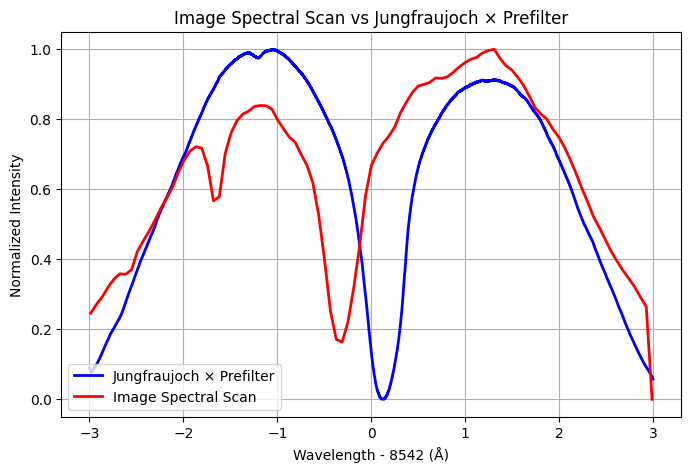

Shift tra minimo ImageScan e Jungfraujoch × Prefilter: -8539.1484 Å


In [ ]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Trova i file FITS
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")
if not fits_files:
    raise FileNotFoundError("No FITS files found.")

# Estrai REL_WAVE da tutti i file
rel_wave_values = []
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            try:
                rel_wave_values.append(hdu.header['REL_WAVE'])
            except KeyError:
                continue

# Trova una immagine valida per definire le regioni
image_data = None
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            if hdu.data is not None and hdu.data.ndim == 2:
                image_data = hdu.data
                break
    if image_data is not None:
        break

if image_data is None:
    raise ValueError("No valid image data found.")

# Definizione regioni
half_size = 25
h, w = image_data.shape
y_center = h // 2
x_center_1 = w // 2 - 220
x_center_2 = w // 2 + 220
x1s, x1e = x_center_1 - half_size, x_center_1 + half_size
x2s, x2e = x_center_2 - half_size, x_center_2 + half_size
ys, ye = y_center - half_size, y_center + half_size

# Media dei valori centrali per ogni HDU (escludendo il PRIMARY)
central_regions = []
with fits.open(fits_files[0]) as hdul:
    for hdu in hdul[1:]:
        data = hdu.data
        if data is not None:
            region1 = data[ys:ye, x1s:x1e]
            region2 = data[ys:ye, x2s:x2e]
            avg_intensity = np.mean([region1.mean(), region2.mean()])
            central_regions.append(avg_intensity)

central_regions = np.array(central_regions)
central_regions = (central_regions - central_regions.min()) / (central_regions.max() - central_regions.min())

# Leggi spettro atlas Jungfraujoch
def read_jung_fits(file, w1, w2, subsample=1):
    skip = round((w1 - 3601) * 1000)
    np_points = (w2 - w1 + 1) * 500
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]
    if sp.dtype.byteorder != '=':
        sp = sp.byteswap().view(sp.dtype.newbyteorder('S'))
    sp = sp.astype(np.float32) * 0.1
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1
    return wave, sp

wave, spectrum = read_jung_fits('/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits', w1=8539, w2=8544)

# Leggi prefilter
file_list = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/prefilter/*8542*.sav")
if not file_list:
    raise FileNotFoundError("No prefilter file found.")
prefilter = readsav(file_list[0])
main_filter = prefilter['prefilt8542_ref_main']

# Interpolazione filtro
old_x = np.linspace(0, 1, len(main_filter))
new_x = np.linspace(0, 1, len(spectrum))
main_filter_resampled = np.interp(new_x, old_x, main_filter)

# Prodotto spettro × filtro e normalizzazione
Im_p = main_filter_resampled * spectrum
Im_p = (Im_p - Im_p.min()) / (Im_p.max() - Im_p.min())

# Plot finale
plt.figure(figsize=(8, 5))
plt.plot(wave - 8542, Im_p, label="Jungfraujoch × Prefilter", color='b', linewidth=2)
plt.plot(rel_wave_values, central_regions, label="Image Spectral Scan", color='r', linewidth=2)
plt.xlabel("Wavelength - 8542 (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Image Spectral Scan vs Jungfraujoch × Prefilter")
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/jungfraujoch_spectrum.png')
plt.show()

# Calcolo dello shift
min_idx_atlas = np.argmin(Im_p)
lambda_atlas = wave[min_idx_atlas]

min_idx_scan = np.argmin(central_regions)
lambda_scan = rel_wave_values[min_idx_scan]

shift_angstrom = lambda_scan - lambda_atlas
print(f"Shift tra minimo ImageScan e Jungfraujoch × Prefilter: {shift_angstrom:.4f} Å")


# ATLAS / PREFILTRO

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(300,)


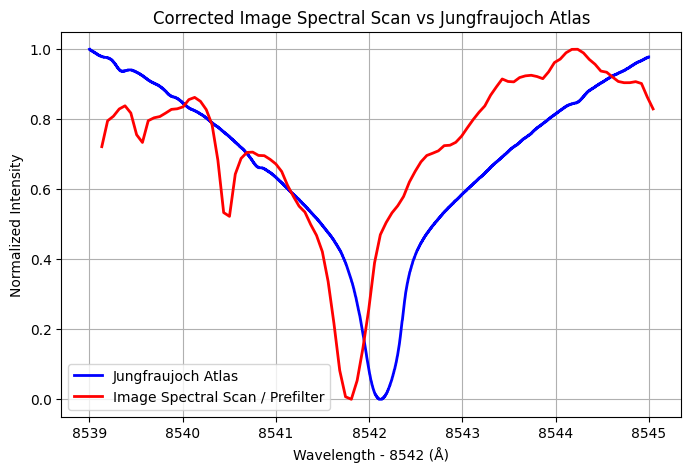

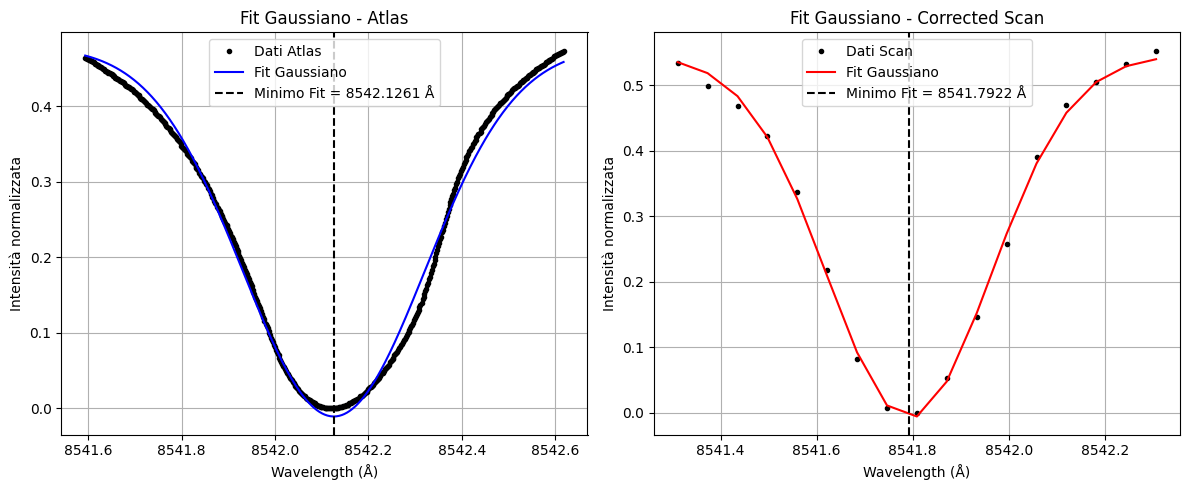

Shift (da fit gaussiano): -0.3339 Å


In [ ]:


import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav

# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Trova i file FITS
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")
if not fits_files:
    raise FileNotFoundError("No FITS files found.")

# Estrai REL_WAVE da tutti i file
rel_wave_values = []
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            try:
                rel_wave_values.append(hdu.header['REL_WAVE'])
            except KeyError:
                continue

# Trova una immagine valida per definire le regioni
image_data = None
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            if hdu.data is not None and hdu.data.ndim == 2:
                image_data = hdu.data
                break
    if image_data is not None:
        break

if image_data is None:
    raise ValueError("No valid image data found.")

# Definizione regioni
half_size = 25
h, w = image_data.shape
y_center = h // 2
x_center_1 = w // 2 - 220
x_center_2 = w // 2 + 220
x1s, x1e = x_center_1 - half_size, x_center_1 + half_size
x2s, x2e = x_center_2 - half_size, x_center_2 + half_size
ys, ye = y_center - half_size, y_center + half_size

# Media dei valori centrali per ogni HDU (escludendo il PRIMARY)
central_regions = []
with fits.open(fits_files[0]) as hdul:
    for hdu in hdul[1:]:
        data = hdu.data
        if data is not None:
            region1 = data[ys:ye, x1s:x1e]
            region2 = data[ys:ye, x2s:x2e]
            avg_intensity = np.mean([region1.mean(), region2.mean()])
            central_regions.append(avg_intensity)

central_regions = np.array(central_regions)


# Normalizza
central_regions = (central_regions - central_regions.min()) / (central_regions.max() - central_regions.min())

# Trova gli indici dei valori zero agli estremi
start_zero = central_regions[0] == 0
end_zero = central_regions[-1] == 0

# Rimuovi i valori zero agli estremi
if start_zero:
    central_regions = central_regions[1:]  # Rimuovi il primo elemento se è zero
    wave_im = np.array(rel_wave_values)[1:]  # Rimuovi il primo elemento in rel_wave_values
if end_zero:
    central_regions = central_regions[:-1]  # Rimuovi l'ultimo elemento se è zero
    wave_im = np.array(rel_wave_values)[:-1]  # Rimuovi l'ultimo elemento in rel_wave_values

wave_im=wave_im+8542.12
# Leggi spettro atlas Jungfraujoch
def read_jung_fits(file, w1, w2, subsample=1):
    skip = round((w1 - 3601) * 1000)
    np_points = (w2 - w1 + 1) * 500
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]
    if sp.dtype.byteorder != '=':
        sp = sp.byteswap().view(sp.dtype.newbyteorder('S'))
    sp = sp.astype(np.float32) * 0.1
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1
    return wave, sp

wave, spectrum = read_jung_fits('/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits', w1=8539, w2=8544)
spectrum_norm = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())

# Leggi prefilter
file_list = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/prefilter/*8542*.sav")
if not file_list:
    raise FileNotFoundError("No prefilter file found.")
prefilter = readsav(file_list[0])
main_filter = prefilter['prefilt8542_ref_main']
print(main_filter.shape)
old_x = np.linspace(0, 1, len(main_filter))  # Griglia originale
new_x = np.linspace(0, 1, len(central_regions))  # Griglia

prefilter_interp = np.interp(new_x, old_x, main_filter)

# Correggi image scan dividendo per il filtro
corrected_scan = central_regions / prefilter_interp
corrected_scan = (corrected_scan - corrected_scan.min()) / (corrected_scan.max() - corrected_scan.min())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wave, spectrum_norm, label="Jungfraujoch Atlas", color='b', linewidth=2)
plt.plot(wave_im , corrected_scan, label="Image Spectral Scan / Prefilter", color='r', linewidth=2)
# plt.plot(np.array(rel_wave_values) , central_regions, label="Image Spectral Scan / Prefilter", color='r', linewidth=2)

plt.xlabel("Wavelength - 8542 (Å)")
plt.ylabel("Normalized Intensity")
plt.title("Corrected Image Spectral Scan vs Jungfraujoch Atlas")
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/corrected_scan_vs_atlas.png')
plt.show()

# Calcolo dello shift
min_idx_atlas = np.argmin(spectrum_norm)
lambda_atlas = wave[min_idx_atlas]

min_idx_scan = np.argmin(corrected_scan)
lambda_scan = wave_im[min_idx_scan]

from scipy.optimize import curve_fit

# Definizione funzione gaussiana per il fit
def gaussian(x, a, x0, sigma, offset):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

# Funzione di fit centrata intorno al minimo
def fit_gaussian_near_min(wavelengths, intensities, window_angstrom):
    min_idx = np.argmin(intensities)
    pixel_scale = wavelengths[1] - wavelengths[0]
    window_pix = int(window_angstrom / pixel_scale)
    start = max(0, min_idx - window_pix // 2)
    end = min(len(intensities), min_idx + window_pix // 2 + 1)

    x = wavelengths[start:end]
    y = intensities[start:end]

    # stima iniziale dei parametri
    a0 = y.min() - y.max()
    x0 = x[np.argmin(y)]
    sigma0 = 0.2
    offset0 = y.max()

    try:
        popt, _ = curve_fit(gaussian, x, y, p0=[a0, x0, sigma0, offset0])
        fitted_min = popt[1]
    except RuntimeError:
        fitted_min = x[np.argmin(y)]  # fallback se il fit fallisce

    return fitted_min, x, y, gaussian(x, *popt)

# Fit per Atlas
lambda_atlas, x_fit_a, y_fit_a, gauss_fit_a = fit_gaussian_near_min(wave, spectrum_norm, 1.0)

# Fit per Corrected Scan
lambda_scan, x_fit_s, y_fit_s, gauss_fit_s = fit_gaussian_near_min(wave_im, corrected_scan, 1.0)

# Plot dei fit
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_fit_a, y_fit_a, 'k.', label='Dati Atlas')
plt.plot(x_fit_a, gauss_fit_a, 'b-', label='Fit Gaussiano')
plt.axvline(lambda_atlas, color='k', linestyle='--', label=f'Minimo Fit = {lambda_atlas:.4f} Å')
plt.title("Fit Gaussiano - Atlas")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensità normalizzata")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_fit_s, y_fit_s, 'k.', label='Dati Scan')
plt.plot(x_fit_s, gauss_fit_s, 'r-', label='Fit Gaussiano')
plt.axvline(lambda_scan, color='k', linestyle='--', label=f'Minimo Fit = {lambda_scan:.4f} Å')
plt.title("Fit Gaussiano - Corrected Scan")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensità normalizzata")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/gaussian_fit_minima.png')
plt.show()

# Calcolo dello shift
shift_angstrom = lambda_scan - lambda_atlas
print(f"Shift (da fit gaussiano): {shift_angstrom:.4f} Å")



# EFEMERIDI


-5.400413473742609
Processing first file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/s000.ImagingSpectralScan_8542.fits
DATE-BEG = 2016-05-20T12:59:44.149


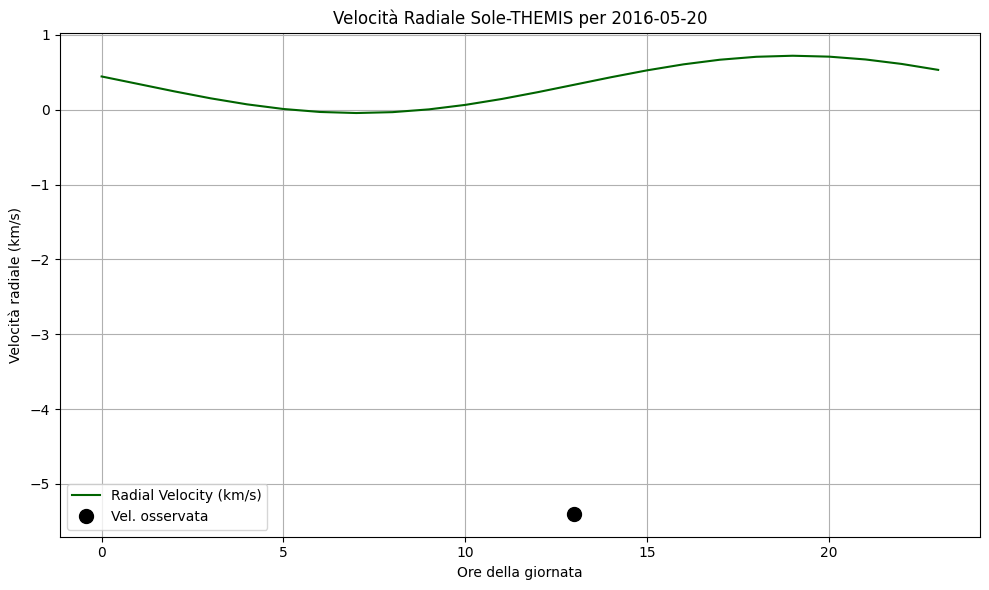

In [8]:
!pip install skyfield

from skyfield.api import Topos, load
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from datetime import datetime

# Carica i dati per il sistema solare
planets = load('de421.bsp')
earth = planets['earth']
sun = planets['sun']

# Coordinate di THEMIS
themis = earth + Topos('28.3022617 N', '16.5086667 W', elevation_m=2390)

# Cerca i FITS file
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan_2016/*8542.fits")

# Shift osservato
shift_obs_angstrom = shift_angstrom
lambda_0 = 8542  # Ångström

# Conversione shift osservato da Å a km/s
shift_obs_velocity = (shift_obs_angstrom / lambda_0) * 300000
print(shift_obs_velocity)

if not fits_files:
    print("No FITS files found in the directory.")
else:
    first_file = fits_files[0]
    print(f"Processing first file: {first_file}")

    with fits.open(first_file) as hdul:
        header = hdul[0].header
        date_beg = header.get('DATE', None)

        if date_beg is None:
            print("DATE-BEG not found in header.")
        else:
            print(f"DATE-BEG = {date_beg}")

            dt = datetime.strptime(date_beg, "%Y-%m-%dT%H:%M:%S.%f")
            year, month, day = dt.year, dt.month, dt.day

            timescale = load.timescale()
            times = timescale.utc(year, month, day, range(24))

            velocities = []

            for t in times:
                sun_pos = sun.at(t)
                obs_pos = themis.at(t)

                vel_diff = sun_pos.velocity.km_per_s - obs_pos.velocity.km_per_s
                pos_diff = sun_pos.position.au - obs_pos.position.au

                radial_velocity = np.dot(vel_diff, pos_diff) / np.linalg.norm(pos_diff)
                velocities.append(radial_velocity)

            velocities = np.array(velocities)

            fig, ax = plt.subplots(figsize=(10, 6))

            ax.plot(range(24), velocities, label='Radial Velocity (km/s)', color='darkgreen')
            ax.set_xlabel('Ore della giornata')
            ax.set_ylabel('Velocità radiale (km/s)')
            ax.set_title(f'Velocità Radiale Sole-THEMIS per {year}-{month:02d}-{day:02d}')
            ax.grid(True)

            obs_hour_decimal = dt.hour + dt.minute / 60 + dt.second / 3600

            # Punto osservato
            ax.plot(obs_hour_decimal, shift_obs_velocity, 'o', color='black', markersize=10, label='Vel. osservata')

            ax.legend()
            plt.tight_layout()
            plt.show()


Velocità osservata: -11.73 km/s
Processing first file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits


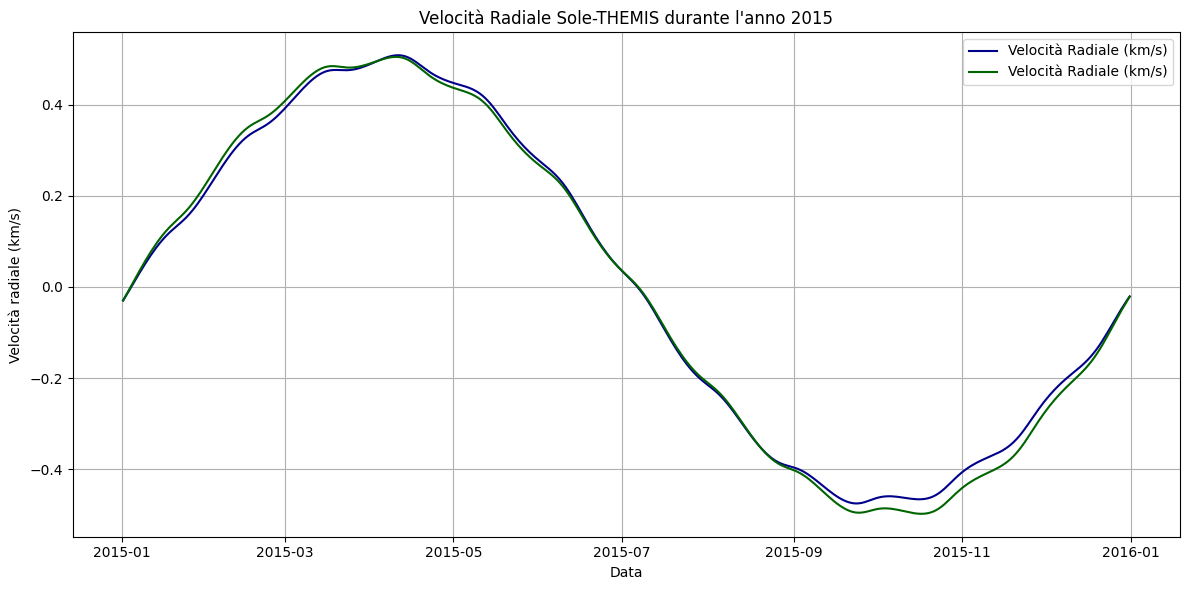

In [ ]:
!pip install skyfield
from skyfield.api import Topos, load,wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from datetime import datetime, timedelta

# Carica i dati per il sistema solare
planets = load('de421.bsp')
earth = planets['earth']
sun = planets['sun']
themis = earth + wgs84.latlon(28.3022617, -16.5086667, elevation_m=2390)

# Cerca i FITS file
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")

# Shift osservato
shift_obs_angstrom = shift_angstrom  # Assicurati che questa variabile sia definita
lambda_0 = 8542  # Ångström
shift_obs_velocity = (shift_obs_angstrom / lambda_0) * 300000
print(f"Velocità osservata: {shift_obs_velocity:.2f} km/s")

if not fits_files:
    print("No FITS files found.")
else:
    first_file = fits_files[0]
    print(f"Processing first file: {first_file}")

    with fits.open(first_file) as hdul:
        header = hdul[0].header
        date_beg = header.get('DATE-BEG', None)

        if date_beg is None:
            print("DATE-BEG not found.")
        else:
            dt = datetime.strptime(date_beg, "%Y-%m-%dT%H:%M:%S.%f")
            obs_hour_decimal = dt.hour + dt.minute / 60 + dt.second / 3600

            timescale = load.timescale()
            velocities = []
            velocities2 = []
            days = []

            for day_offset in range(365):
                current_day = dt.replace(month=1, day=1) + timedelta(days=day_offset)
                t = timescale.utc(current_day.year, current_day.month, current_day.day, obs_hour_decimal)

                sun_pos = sun.at(t)
                obs_pos = themis.at(t)
                obs_pos2=earth.at(t)

                vel_diff = sun_pos.velocity.km_per_s - obs_pos.velocity.km_per_s
                vel_diff2= sun_pos.velocity.km_per_s - obs_pos2.velocity.km_per_s
                pos_diff = sun_pos.position.au - obs_pos.position.au


                pos_diff2 = sun_pos.position.au - obs_pos2.position.au

                radial_velocity = np.dot(vel_diff, pos_diff) / np.linalg.norm(pos_diff)
                radial_velocity2 = np.dot(vel_diff2, pos_diff2) / np.linalg.norm(pos_diff2)
                velocities2.append(radial_velocity2)
                velocities.append(radial_velocity)
                days.append(current_day)

            velocities = np.array(velocities)
            velocities2 = np.array(velocities2)
            days = np.array(days)

            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(days, velocities, label='Velocità Radiale (km/s)', color='darkblue')
            ax.plot(days, velocities2, label='Velocità Radiale (km/s)', color='darkgreen')
            # ax.axhline(shift_obs_velocity, color='black', linestyle='--', label='Vel. osservata')

            ax.set_xlabel('Data')
            ax.set_ylabel('Velocità radiale (km/s)')
            ax.set_title(f'Velocità Radiale Sole-THEMIS durante l\'anno {dt.year}')
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()


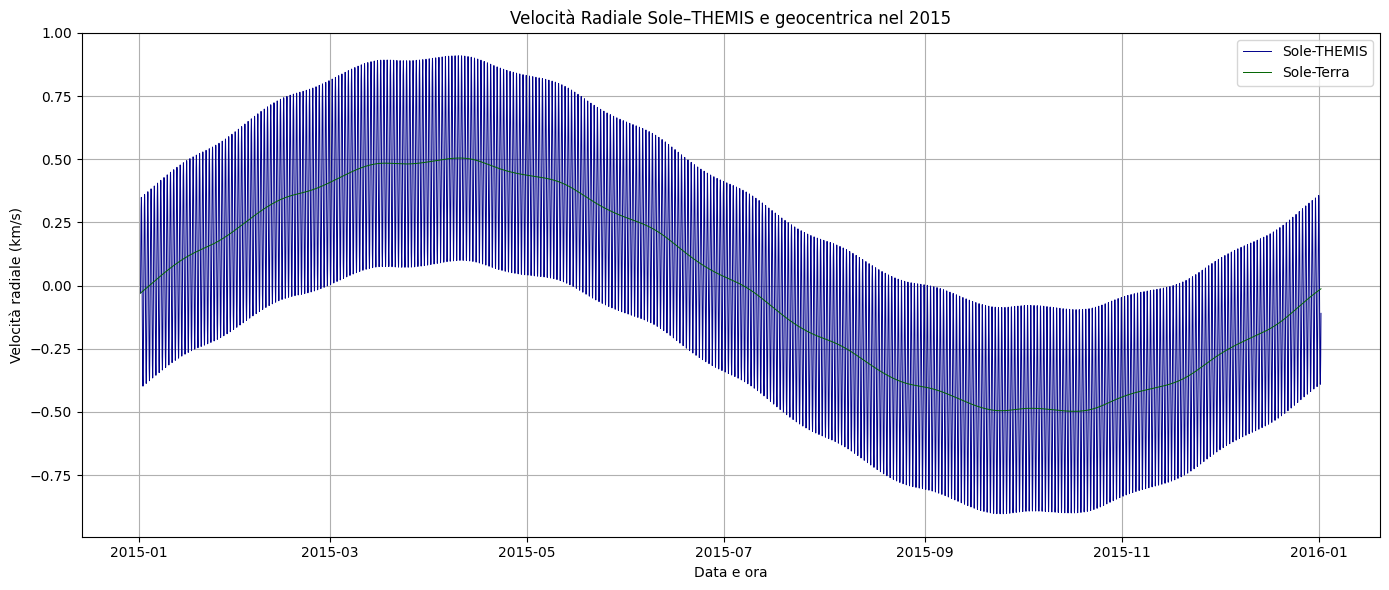

In [ ]:
!pip install skyfield
from skyfield.api import load, wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from datetime import datetime, timedelta

# Carica i dati planetari
planets = load('de421.bsp')
earth = planets['earth']
sun = planets['sun']
themis = earth + wgs84.latlon(28.3022617, -16.5086667, elevation_m=2390)

# Cerca il primo file FITS
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")
shift_angstrom = 0.1  # <-- Sostituisci con il tuo valore reale
lambda_0 = 8542
shift_obs_velocity = (shift_angstrom / lambda_0) * 300000

if not fits_files:
    print("No FITS files found.")
else:
    with fits.open(fits_files[0]) as hdul:
        header = hdul[0].header
        date_beg = header.get('DATE-BEG')

        if date_beg is None:
            print("DATE-BEG not found in FITS header.")
        else:
            dt_start = datetime.strptime(date_beg, "%Y-%m-%dT%H:%M:%S.%f")
            year = dt_start.year

            timescale = load.timescale()
            velocities_themis = []
            velocities_earth = []
            timestamps = []

            for day_offset in range(365):
                for hour in range(24):
                    current_time = dt_start.replace(month=1, day=1) + timedelta(days=day_offset, hours=hour)
                    t = timescale.utc(current_time.year, current_time.month, current_time.day,
                                      current_time.hour, current_time.minute, current_time.second)

                    # THEMIS
                    obs_pos = themis.at(t)
                    sun_pos = sun.at(t)
                    vel_diff = sun_pos.velocity.km_per_s - obs_pos.velocity.km_per_s
                    pos_diff = sun_pos.position.au - obs_pos.position.au
                    vr_themis = np.dot(vel_diff, pos_diff) / np.linalg.norm(pos_diff)
                    velocities_themis.append(vr_themis)

                    # Geocentrico
                    obs_pos_earth = earth.at(t)
                    vel_diff_earth = sun_pos.velocity.km_per_s - obs_pos_earth.velocity.km_per_s
                    pos_diff_earth = sun_pos.position.au - obs_pos_earth.position.au
                    vr_earth = np.dot(vel_diff_earth, pos_diff_earth) / np.linalg.norm(pos_diff_earth)
                    velocities_earth.append(vr_earth)

                    timestamps.append(current_time)

            # Plot
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(timestamps, velocities_themis, label='Sole-THEMIS', color='darkblue', linewidth=0.7)
            ax.plot(timestamps, velocities_earth, label='Sole-Terra', color='darkgreen', linewidth=0.7)
            # ax.axhline(shift_obs_velocity, color='black', linestyle='--', label='Vel. osservata')

            ax.set_xlabel('Data e ora')
            ax.set_ylabel('Velocità radiale (km/s)')
            ax.set_title(f'Velocità Radiale Sole–THEMIS e geocentrica nel {year}')
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()


Velocità osservata: -11.73 km/s
Processing first file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits


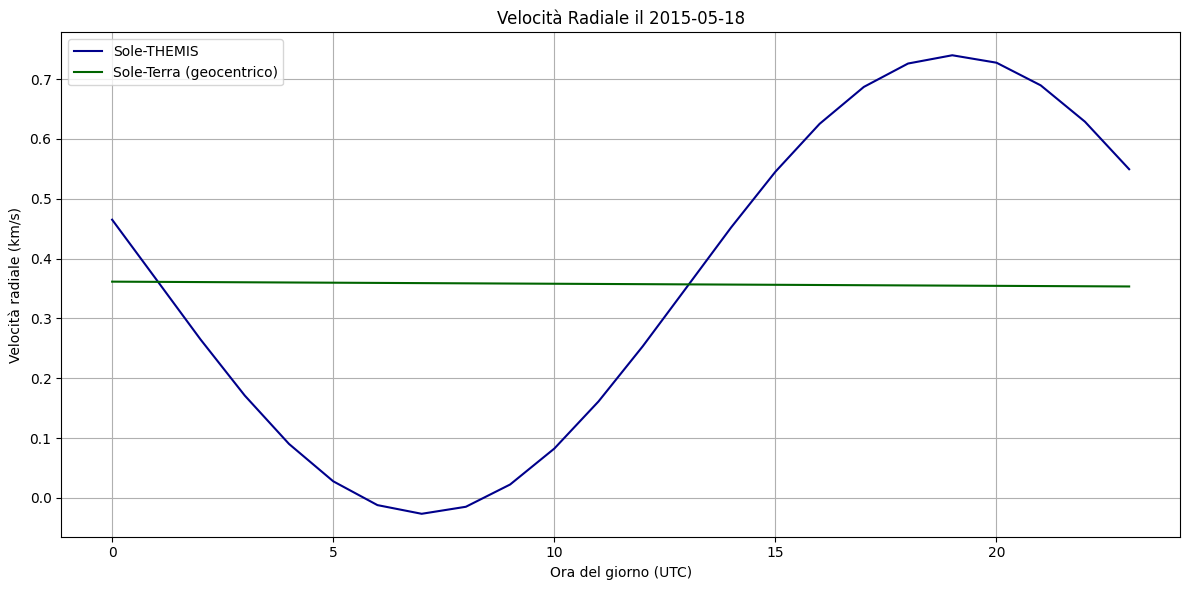

In [ ]:
!pip install skyfield
from skyfield.api import Topos, load, wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from datetime import datetime

# Carica i dati per il sistema solare
planets = load('de421.bsp')
earth = planets['earth']
sun = planets['sun']
themis = earth + wgs84.latlon(28.3022617, -16.5086667, elevation_m=2390)

# Cerca i FITS file
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")

# Shift osservato
shift_obs_angstrom = shift_angstrom  # Assicurati che questa variabile sia definita
lambda_0 = 8542
shift_obs_velocity = (shift_obs_angstrom / lambda_0) * 300000
print(f"Velocità osservata: {shift_obs_velocity:.2f} km/s")

if not fits_files:
    print("No FITS files found.")
else:
    first_file = fits_files[0]
    print(f"Processing first file: {first_file}")

    with fits.open(first_file) as hdul:
        header = hdul[0].header
        date_beg = header.get('DATE-BEG', None)

        if date_beg is None:
            print("DATE-BEG not found.")
        else:
            dt = datetime.strptime(date_beg, "%Y-%m-%dT%H:%M:%S.%f")
            year, month, day = dt.year, dt.month, dt.day

            timescale = load.timescale()
            hours = np.arange(0, 24)
            velocities = []
            velocities2 = []

            for h in hours:
                t = timescale.utc(year, month, day, h)

                sun_pos = sun.at(t)
                obs_pos = themis.at(t)
                obs_pos2 = earth.at(t)

                vel_diff = sun_pos.velocity.km_per_s - obs_pos.velocity.km_per_s
                pos_diff = sun_pos.position.au - obs_pos.position.au
                radial_velocity = np.dot(vel_diff, pos_diff) / np.linalg.norm(pos_diff)
                velocities.append(radial_velocity)

                vel_diff2 = sun_pos.velocity.km_per_s - obs_pos2.velocity.km_per_s
                pos_diff2 = sun_pos.position.au - obs_pos2.position.au
                radial_velocity2 = np.dot(vel_diff2, pos_diff2) / np.linalg.norm(pos_diff2)
                velocities2.append(radial_velocity2)

            velocities = np.array(velocities)
            velocities2 = np.array(velocities2)

            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(hours, velocities, label='Sole-THEMIS', color='darkblue')
            ax.plot(hours, velocities2, label='Sole-Terra (geocentrico)', color='darkgreen')
            # ax.axhline(shift_obs_velocity, color='black', linestyle='--', label='Vel. osservata')

            ax.set_xlabel('Ora del giorno (UTC)')
            ax.set_ylabel('Velocità radiale (km/s)')
            ax.set_title(f'Velocità Radiale il {year}-{month:02d}-{day:02d}')
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()


In [ ]:
sun_geocentric = earth.at(t).observe(sun)
vel = sun_geocentric.velocity.km_per_s
pos = sun_geocentric.position.au

print(pos)
sun_geocentric.apparent().distance()

[ 0.1589842  -0.89032097 -0.38596424]


<Distance 0.983319 au>

# Image spectral scan

In [ ]:
import glob
import matplotlib.pyplot as plt
from astropy.io import fits

fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")

if not fits_files:
    print("No FITS files found in the directory.")
else:
    rel_wave_values = []  # we crete a list of wavelength values associated with each image spectral scal


    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            print(f"Processing file: {fits_file}")
            # hdul.info()  # just to show the HDU structure


            for i, hdu in enumerate(hdul):
                header = hdu.header

                # We extract the wavelength values
                try:
                    rel_wave = header['REL_WAVE']
                    rel_wave_values.append(rel_wave)
                    # print(f"  HDU {i} ({hdu.name}): REL_WAVE = {rel_wave}")
                except KeyError:
                     print(f"  HDU {i} ({hdu.name}): REL_WAVE keyword not found.")


                # if hdu.data is not None and hdu.data.ndim in [2, 3]:
                #     plt.figure(figsize=(8, 8))
                #     plt.imshow(hdu.data, cmap='gray', origin='lower')
                #     plt.colorbar(label='Intensity')
                #     plt.title(f'FITS Image - HDU {i}')
                #     plt.xlabel('X Pixel')
                #     plt.ylabel('Y Pixel')
                #     plt.show()

# # We check the wavelengths values
# if rel_wave_values:
#     print("\nAll REL_WAVE values:")
#     for value in rel_wave_values:
#         print(value)
# else:
#     print("\nNo REL_WAVE values found.")


No FITS files found in the directory.


In [ ]:
fits_files = glob.glob("/content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/*8542.fits")

if not fits_files:
    print("No FITS files found in the directory.")
else:
    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            print(f"Processing file: {fits_file}")
            # We only access the first HDU (index 0)
            hdu = hdul[0]
            header = hdu.header
            print(f"  First HDU ({hdu.name}) Header Keywords:")
            for keyword, value in header.items():
                print(f"    {keyword} = {value}")
            print("-" * 20) # Separator for readability

Processing file: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits
  First HDU (PRIMARY) Header Keywords:
    SIMPLE = True
    BITPIX = 16
    NAXIS = 0
    EXTEND = True
    BINNING = 1
    BSCALE = 1.0
    BZERO = 0.0
    BUNIT = Counts
    DATE = 2015-05-18T13:09:32.983
    ORIGIN = NSO/SP
    TELESCOP = NSO - DST
    INSTRUME = IBIS
    DETECTOR = ANDOR iXon 885
    FILENAME = \ImagingSpectralScan\20150518_130928\s000.ImagingSpectralScan.fits
    FILEORIG = \ImagingSpectralScan\20150518_130928\s000.ImagingSpectralScan.fits
    DATE-BEG = 2015-05-18T13:09:32.978
    DATE-END = 2015-05-18T13:09:33.018
    CCD_TEMP = -60
    CCDATEMP = -59
    EXP_EFF = 0.04
    GAIN_PRE = X2
    GAIN_EM = 0
    SER_NUM = 2748
    OBSERVER = Doug/Hillary
    WL_PRFLT = 633
    CHANNEL = Narrowband
    SEQ_NUM = s000
    SERIESID = 20150518_130928
    BASECLMP = 100
    X_START = 1
    Y_START = 1
--------------------


Selected image from: /content/drive/MyDrive/IBIS_SWG/input/ImageSpectralScan/s000.ImagingSpectralScan_8542.fits


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | ColorizingArtist | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

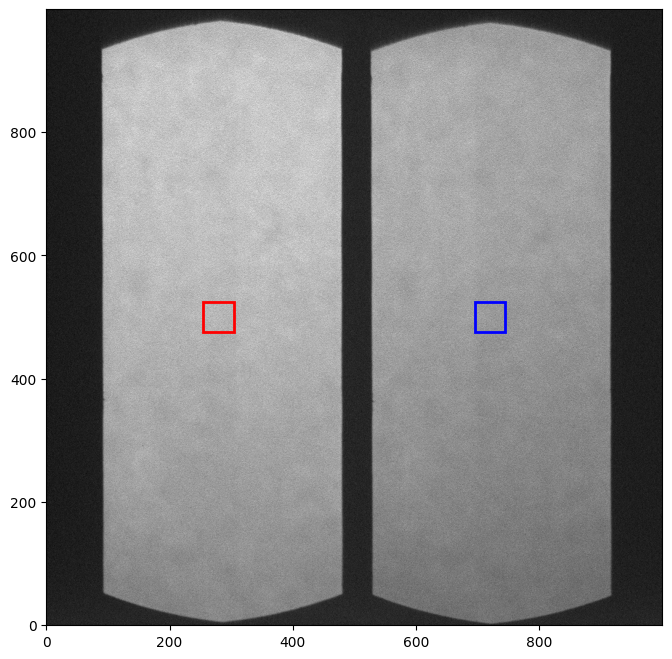

In [ ]:
from matplotlib.patches import Rectangle

image_data = None  # inizializzazione

# Cerchiamo il primo file con dati validi da usare per image_data
for fits_file in fits_files:
    with fits.open(fits_file) as hdul:
        for hdu in hdul:
            if hdu.data is not None and hdu.data.ndim == 2:
                image_data = hdu.data
                print(f"Selected image from: {fits_file}")
                break
    if image_data is not None:
        break

if image_data is None:
    raise ValueError("No valid image data found in the FITS files.")

# We select the parameters to evaluate the average of the center
half_size = 25  # half of the dimensions of the region we want (50x50)

image_height, image_width = image_data.shape

# center in y (half of the image height)
y_center = image_height // 2

# Region 1 (x centered at half of the width - 220)
x_center_1 = image_width // 2 - 220
x_start_1 = x_center_1 - half_size
x_end_1 = x_center_1 + half_size

# Regione 2 (x centered at half of the width + 220)
x_center_2 = image_width // 2 + 220
x_start_2 = x_center_2 - half_size
x_end_2 = x_center_2 + half_size

# Evaluate the indexes of starting and ending of the regions
y_start = y_center - half_size
y_end = y_center + half_size


# Plot with box the two regions
plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='gray', origin='lower')


rect1 = Rectangle((x_start_1, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none')
plt.gca().add_patch(rect1)


rect2 = Rectangle((x_start_2, y_start),
                    width=2*half_size,
                    height=2*half_size,
                    linewidth=2,
                    edgecolor='b',
                    facecolor='none')
plt.gca().add_patch(rect2)

plt.colorbar

In [ ]:
if fits_files:
    with fits.open(fits_files[0]) as hdul:

        central_regions = []

        # We iterate all the HDUs (excluding the PRIMARY HDU)
        for hdu in hdul[1:]:
            data = hdu.data
            if data is not None:
                # We extract the two regions
                region_1 = data[y_start:y_end, x_start_1:x_end_1]
                region_2 = data[y_start:y_end, x_start_2:x_end_2]

                # We evaluate the mean
          stic/0_Synthesis
                central_regions.append(central_region)

central_regions = (central_regions-np.min(central_regions)) / (np.max(central_regions)-np.min(central_regions))

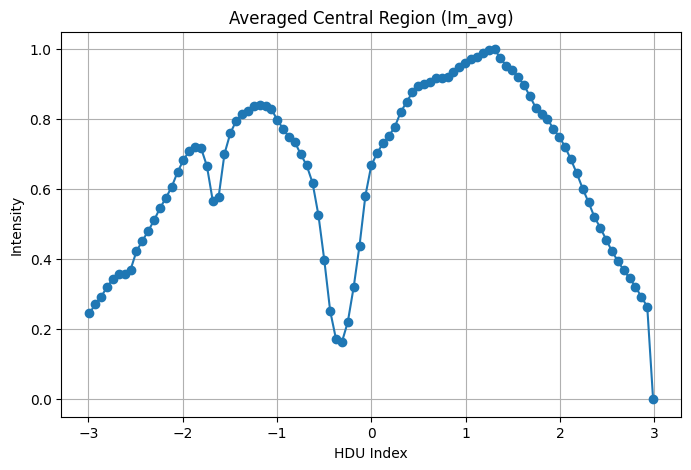

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(rel_wave_values, central_regions, marker='o', linestyle='-')
plt.title('Averaged Central Region (Im_avg)')
plt.xlabel('HDU Index')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()


# ATLAS


In [ ]:


def read_jung_fits(file, w1, w2, subsample=1):
    """
    Reads the Jungfraujoch solar spectrum from a FITS file.

    Parameters:
    - file: str, path to the FITS file.
    - w1: int, starting wavelength (Å).
    - w2: int, ending wavelength (Å).
    - subsample: int, optional, subsampling factor (default=1).

    Returns:
    - wave: numpy array, wavelength array.
    - sp: numpy array, spectral intensities.
    """

    # --- Help message ---
    if w1 is None or w2 is None:
        print("Usage: read_jung_fits(file, w1, w2, subsample=ss)")
        print("Wavelength limits: 3601 to 9300 Å")
        print("Subsample should be in {1,2,4,5,10,20,50,100,250,500}")
        return

    # --- Check inputs ---
    if w1 < 3601:
        raise ValueError(f"Error: Min wavelength is 3601 Å. Given: {w1}")
    if w2 > 9300:
        raise ValueError(f"Error: Max wavelength is 9300 Å. Given: {w2}")
    if w2 < w1:
        raise ValueError("Error: Max wavelength is smaller than min wavelength")

    # --- Calculate byte skip ---
    skip = round((w1 - 3601) * 1000)    # 2880 is the FITS header size

    np_points = (w2 - w1 + 1) * 500  # 500 points per Angstrom

    # --- Open the FITS file and read the data ---
    with fits.open(file, memmap=True) as hdul:
        raw_data = hdul[0].data
        header = hdul[0].header

    # --- Extract the portion of interest ---
    sp = raw_data.flatten()[skip // 2: skip // 2 + np_points]

    # # --- Byte order correction (like IDL's `byteorder`) ---
    if sp.dtype.byteorder != '=':  # Native byte order
        sp = sp.byteswap().view(sp.dtype.newbyteorder('S'))


    # --- Convert from int16 to float and scale ---
    sp = sp.astype(np.float32) * 0.1

    # --- Apply subsampling if needed ---
    if subsample > 1:
        sp = sp.reshape(-1, subsample).mean(axis=1)

    # --- Create wavelength array ---
    wave = np.arange(len(sp), dtype=np.float32) * 0.002 * subsample + w1

    return wave, sp


1553


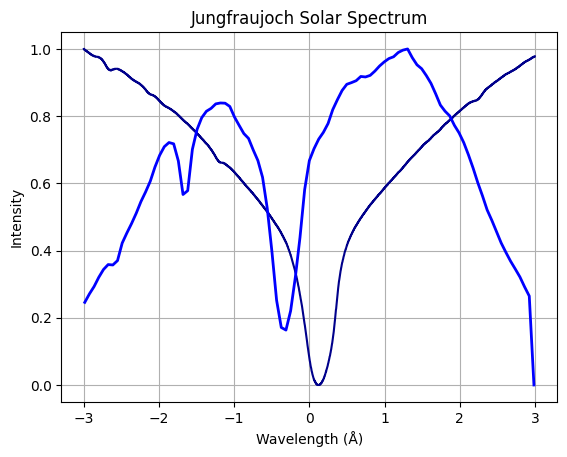

(3000,)


In [ ]:
# File path
file = '/content/drive/MyDrive/IBIS_SWG/input/atlas/jun.fits'

wave, spectrum = read_jung_fits(file, w1=8539, w2=8544)
# Find the index of the minimum value.
min_index_atlas = np.argmin(spectrum)
print(min_index_atlas)
sp_norm=(spectrum-np.min(spectrum))/((np.max(spectrum))-np.min(spectrum))


# Plot the spectrum

plt.plot(wave-8542, sp_norm, color="darkblue")
plt.plot(rel_wave_values, central_regions, label="Image_spectralscan", color='b', linewidth=2)

plt.title("Jungfraujoch Solar Spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Intensity")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/IBIS_SWG/output/jungfraujoch_spectrum.png') # Save the plot
plt.show()
print(sp_norm.shape)

In [ ]:



file_pattern = "/content/drive/MyDrive/IBIS_SWG/input/prefilter/*8542*.sav"
file_list = glob.glob(file_pattern)

if not file_list:
    print("No files found matching the pattern.")
else:
    for file_path in file_list:
        try:
            prefilter = readsav(file_path)
            print(f"Successfully read: {file_path}")
            # `data` is a dictionary-like object containing variables
        except Exception as e:
            print(f"Error reading {file_path}: {e}")




Successfully read: /content/drive/MyDrive/IBIS_SWG/input/prefilter/prefilter.8542.reference.profile.Apr2015.sav


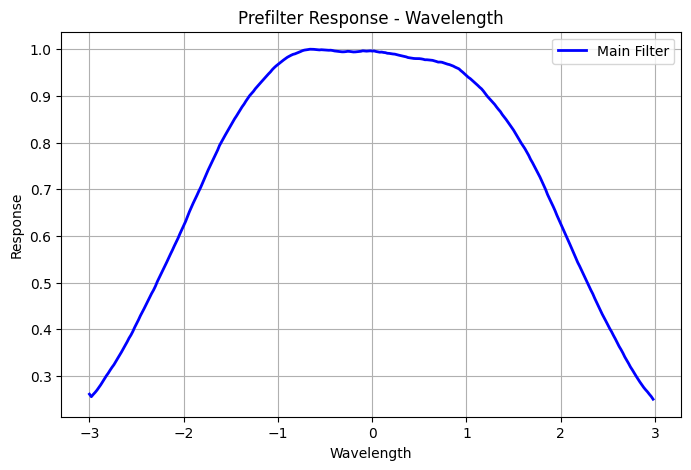

(300,)


In [ ]:

# Extract data
wavelengths = prefilter['prefilt8542_ref_wvscl']  # X-axis (wavelength scale)
main_filter = prefilter['prefilt8542_ref_main']   # Y-axis (main filter response)
fringe_filter = prefilter['prefilt8542_fringe']  # Y-axis (fringe response)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, main_filter, label="Main Filter", color='b', linewidth=2)


# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Prefilter Response - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()
print(main_filter.shape)


Dimensione di Im_p: (3000,)


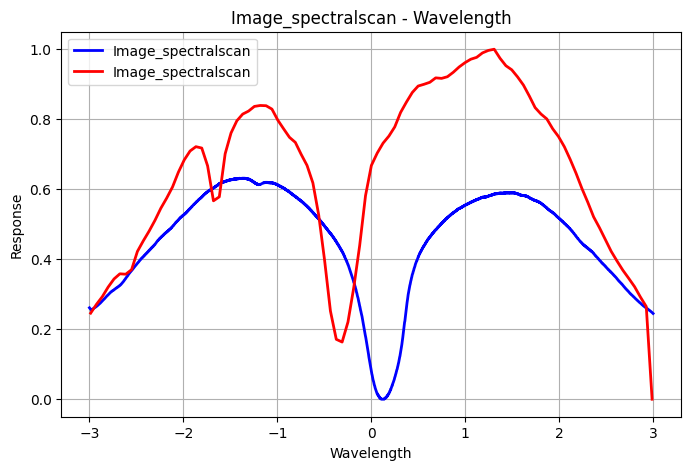

In [ ]:
# Now we interpolate the Image  spectral scan profile on the Prefilter grid, to compare them0

old_x = np.linspace(0, 1, 300)  # Griglia originale
new_x = np.linspace(0, 1, 3000)  # Griglia

main_filter_resampled = np.interp(new_x, old_x, main_filter)

# Ora i due array sono compatibili
Im_p = main_filter_resampled*sp_norm

print(f"Dimensione di Im_p: {Im_p.shape}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(wave-8542, Im_p, label="Image_spectralscan", color='b', linewidth=2)
plt.plot(rel_wave_values, central_regions, label="Image_spectralscan", color='r', linewidth=2)

# Labels and title
plt.xlabel("Wavelength")
plt.ylabel("Response")
plt.title("Image_spectralscan - Wavelength")
plt.legend()
plt.grid()

# Show plot
plt.show()

